In [1]:
from models.srm_net import SRM_Net

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 9 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [4]:
W_syn_init = 0
W_spk_init = 0
Tau_syn_init = 0
Tau_spk_init = 0
Delta_syn_init = 0
Delta_spk_init = 0

In [5]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = SRM_Net(C_den, C_syn_e, C_syn_i, T_no, 
            W_syn_init, W_spk_init,
            Tau_syn_init, Tau_spk_init,
            Delta_syn_init, Delta_spk_init,
            device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

120


In [7]:
tau = 10

t = torch.arange(T_no).to(device)
t_tau = t / tau
kern = t_tau * torch.exp(-t_tau)
kern = torch.flip(kern, [0]).reshape(1,1,-1)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_pred, out_filters = model(batch_E_neural, batch_I_neural)
    
    spk_pred = F.conv1d(Z_pred[:,0].reshape(1,1,-1), kern, padding=250).flatten()
    batch_spk = F.conv1d(batch_Z.reshape(1,1,-1), kern, padding=250).flatten()
        
    loss = torch.mean((spk_pred - batch_spk)**2)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_Z_pred, test_out_filters = model(test_E_neural, test_I_neural)
        
        test_spk_pred = F.conv1d(test_Z_pred[:,0].reshape(1,1,-1), kern, padding=250).flatten()
        test_spk = F.conv1d(Z_test.reshape(1,1,-1), kern, padding=250).flatten()
         
        test_mse = torch.mean((test_spk_pred - test_spk)**2).item()
        test_var = explained_variance_score(test_spk.cpu().detach().numpy(), test_spk_pred.cpu().detach().numpy())
        
        print(i, 
              "TEST_VAR:", np.round(test_var, 5),
              "TEST_MSE:", np.round(test_mse, 5),
              "TAU_SYN:", np.round(torch.mean(model.Tau_syn_e).item(), 5),
              "TAU_SPK:", np.round(torch.mean(model.Tau_spk).item(), 5),
              "W_SYN:", np.round(torch.mean(model.W_syn_e).item(), 5),
              "W_SPK:", np.round(torch.mean(model.W_spk).item(), 5),
             )


<ipython-input-7-fec06f116a1b>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 TEST_VAR: -118.04813 TEST_MSE: 0.38061 TAU_SYN: -0.02644 TAU_SPK: -0.01388 W_SYN: 0.0 W_SPK: -0.01413
199 TEST_VAR: -83.68652 TEST_MSE: 0.26668 TAU_SYN: -0.04701 TAU_SPK: -0.02201 W_SYN: 0.0 W_SPK: -0.02295
299 TEST_VAR: -60.99897 TEST_MSE: 0.19345 TAU_SYN: -0.06348 TAU_SPK: -0.02911 W_SYN: 0.0 W_SPK: -0.03081
399 TEST_VAR: -47.19471 TEST_MSE: 0.1497 TAU_SYN: -0.07765 TAU_SPK: -0.03521 W_SYN: 0.0 W_SPK: -0.03766
499 TEST_VAR: -36.50096 TEST_MSE: 0.11584 TAU_SYN: -0.09221 TAU_SPK: -0.0411 W_SYN: 0.0 W_SPK: -0.04438
599 TEST_VAR: -29.78028 TEST_MSE: 0.09489 TAU_SYN: -0.10439 TAU_SPK: -0.04626 W_SYN: 0.0 W_SPK: -0.05034
699 TEST_VAR: -26.14552 TEST_MSE: 0.08278 TAU_SYN: -0.1162 TAU_SPK: -0.05129 W_SYN: 0.0 W_SPK: -0.05624
799 TEST_VAR: -23.42282 TEST_MSE: 0.07361 TAU_SYN: -0.12696 TAU_SPK: -0.05607 W_SYN: 0.0 W_SPK: -0.06176
899 TEST_VAR: -21.10942 TEST_MSE: 0.06583 TAU_SYN: -0.13573 TAU_SPK: -0.06013 W_SYN: 0.0 W_SPK: -0.06658
999 TEST_VAR: -19.43035 TEST_MSE: 0.06007 TAU_SYN: -0.1453

7999 TEST_VAR: -0.74393 TEST_MSE: 0.00375 TAU_SYN: -0.45556 TAU_SPK: -0.18596 W_SYN: 0.0 W_SPK: -0.22957
8099 TEST_VAR: -0.70048 TEST_MSE: 0.00366 TAU_SYN: -0.46179 TAU_SPK: -0.18803 W_SYN: 0.0 W_SPK: -0.23251
8199 TEST_VAR: -0.7005 TEST_MSE: 0.00366 TAU_SYN: -0.46866 TAU_SPK: -0.19032 W_SYN: 0.0 W_SPK: -0.23592
8299 TEST_VAR: -0.67452 TEST_MSE: 0.0036 TAU_SYN: -0.47552 TAU_SPK: -0.19318 W_SYN: 0.0 W_SPK: -0.24012
8399 TEST_VAR: -0.65348 TEST_MSE: 0.00356 TAU_SYN: -0.48158 TAU_SPK: -0.19572 W_SYN: 0.0 W_SPK: -0.24388
8499 TEST_VAR: -0.67424 TEST_MSE: 0.0036 TAU_SYN: -0.4861 TAU_SPK: -0.19765 W_SYN: 0.0 W_SPK: -0.24661
8599 TEST_VAR: -0.61865 TEST_MSE: 0.00348 TAU_SYN: -0.49359 TAU_SPK: -0.20036 W_SYN: 0.0 W_SPK: -0.25072
8699 TEST_VAR: -0.66497 TEST_MSE: 0.00358 TAU_SYN: -0.50305 TAU_SPK: -0.20383 W_SYN: 0.0 W_SPK: -0.25586
8799 TEST_VAR: -0.66497 TEST_MSE: 0.00358 TAU_SYN: -0.50643 TAU_SPK: -0.20513 W_SYN: 0.0 W_SPK: -0.25799
8899 TEST_VAR: -0.62928 TEST_MSE: 0.00351 TAU_SYN: -0.5162 

IndexError: index 9900 is out of bounds for dimension 0 with size 9900

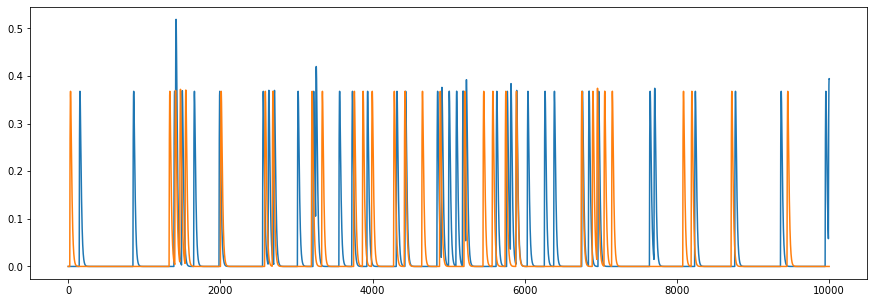

In [8]:
plt.figure(figsize = (15,5))
plt.plot(test_spk.cpu().detach().numpy()[16000:26000])
plt.plot(test_spk_pred.cpu().detach().numpy()[16000:26000])

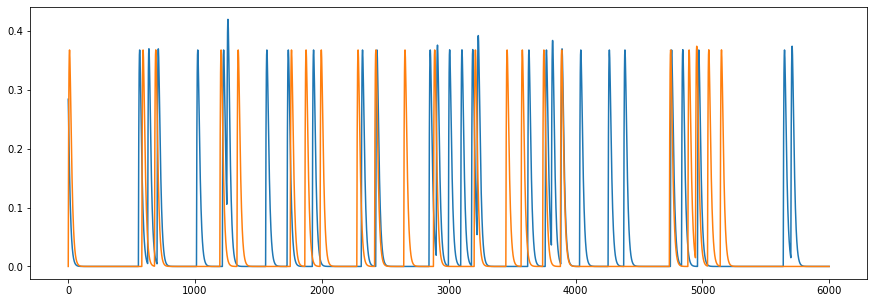

In [9]:
plt.figure(figsize = (15,5))
plt.plot(test_spk.cpu().detach().numpy()[16000:26000][2000:8000])
plt.plot(test_spk_pred.cpu().detach().numpy()[16000:26000][2000:8000])

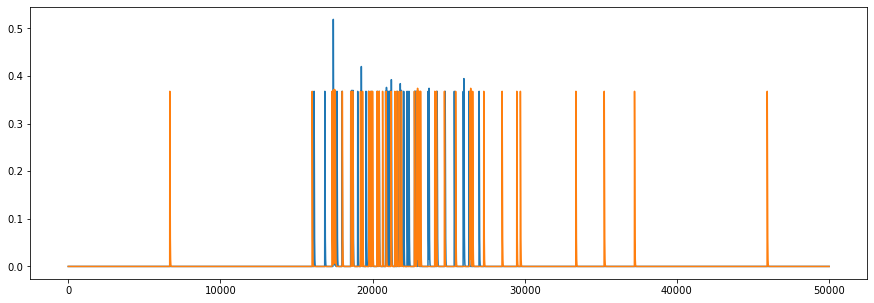

In [10]:
plt.figure(figsize = (15,5))
plt.plot(test_spk.cpu().detach().numpy())
plt.plot(test_spk_pred.cpu().detach().numpy())